#### Credit: This code is pretty much copied from the book: "Generative Adverserial Networks with Python" from Machine Learning Mastery

In [1]:
# Imports
import os

# example of a dcgan on cifar10
import numpy as np
import scipy
import skimage
# from numpy import zeros
# from numpy import ones
# from numpy.random import randn
# from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup to use CPU for now
os.environ['CUDA_VISIBLE_DEVICES']='1'   # '' = CPU, 0' = GPU0, '1' = GPU1

In [3]:
# Load CIFAR10
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


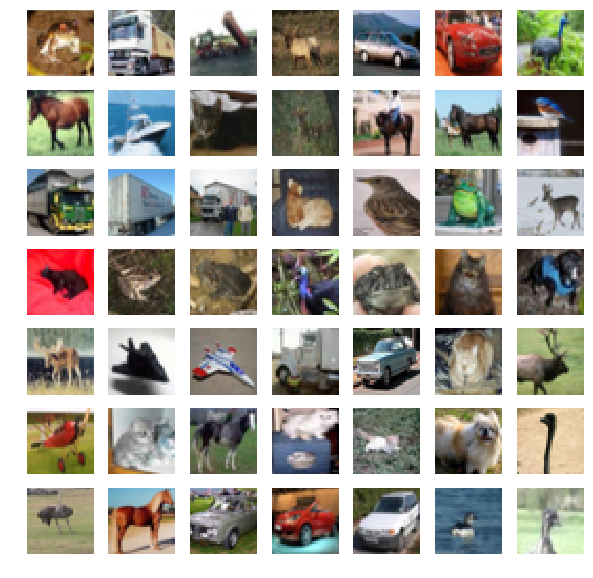

In [4]:
# plot images from the training dataset
resize_1x = (32,32,3)
resize_2x = (64,64,3)
resize_4x = (128,128,3)

plt.figure(figsize=(10,10))
for i in range(49):
    # define subplot
    plt.subplot(7, 7, 1 + i)
    # turn off axis
    plt.axis('off')
    # img = skimage.transform.resize(trainX[i], resize_2x)
    img = trainX[i]
    # plot raw pixel data
    plt.imshow(img)
plt.show()

In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [8]:
# load and prepare cifar10 training images
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [9]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [10]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [11]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [12]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    # save plot to file
    filename = 'gan_cifar10_mlm/generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [13]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'gan_cifar10_mlm/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [14]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            # print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            #    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [15]:
##### Now do it all! ####
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
dataset.shape

(50000, 32, 32, 3)

In [18]:
type(dataset)

numpy.ndarray

In [16]:
# train model
NUM_EPOCHS = 200
NUM_BATCH = 128
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=NUM_EPOCHS, n_batch=NUM_BATCH)

Instructions for updating:
Use tf.cast instead.


/home/ggopalan/anaconda3/envs/ggpy3_gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10, 390/390, d1=0.699, d2=0.402 g=1.732
>Accuracy real: 77%, fake: 95%
>20, 390/390, d1=0.769, d2=0.621 g=0.900
>Accuracy real: 53%, fake: 84%
>30, 390/390, d1=0.652, d2=0.662 g=0.880
>Accuracy real: 55%, fake: 67%
>40, 390/390, d1=0.650, d2=0.654 g=0.842
>Accuracy real: 55%, fake: 74%
>50, 390/390, d1=0.690, d2=0.621 g=0.873
>Accuracy real: 41%, fake: 84%
>60, 390/390, d1=0.703, d2=0.646 g=0.889
>Accuracy real: 51%, fake: 77%
>70, 390/390, d1=0.634, d2=0.611 g=0.879
>Accuracy real: 66%, fake: 83%
>80, 390/390, d1=0.652, d2=0.561 g=0.944
>Accuracy real: 54%, fake: 87%
>90, 390/390, d1=0.608, d2=0.643 g=0.954
>Accuracy real: 52%, fake: 83%
>100, 390/390, d1=0.694, d2=0.575 g=0.974
>Accuracy real: 60%, fake: 89%
>110, 390/390, d1=0.618, d2=0.624 g=0.993
>Accuracy real: 55%, fake: 85%
>120, 390/390, d1=0.558, d2=0.568 g=1.093
>Accuracy real: 62%, fake: 90%
>130, 390/390, d1=0.514, d2=0.630 g=1.069
>Accuracy real: 58%, fake: 81%
>140, 390/390, d1=0.502, d2=0.673 g=1.126
>Accuracy real: 69

In [5]:
# generate points in latent space as input for the generator
def generate_latent_points_again(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

/home/ggopalan/anaconda3/envs/ggpy3_gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


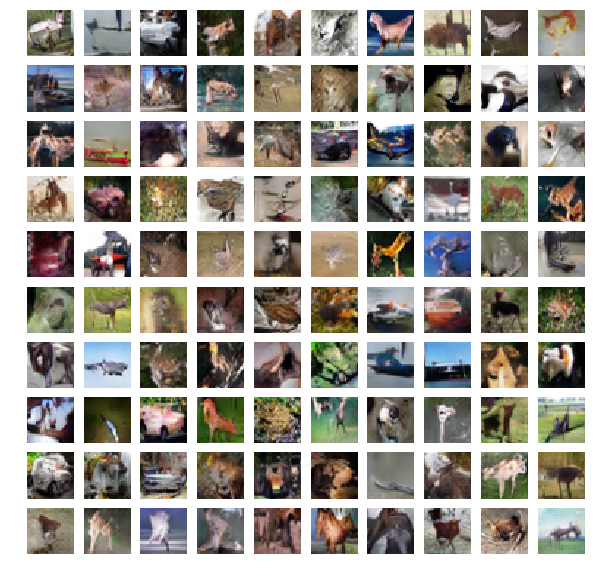

In [18]:
LOAD_N_SHOW = True
if LOAD_N_SHOW:
    # load model
    model = load_model('gan_cifar10_mlm/generator_model_200.h5')
    # generate images
    latent_points = generate_latent_points_again(100, 100)
    # generate images
    X = model.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot the result
    save_plot(X, 10)

/home/ggopalan/anaconda3/envs/ggpy3_gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


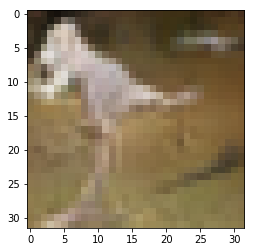

In [17]:
LOAD_N_SHOW_SINGLE = True
if LOAD_N_SHOW_SINGLE:
    # example of generating an image for a specific point in the latent space
    # load model
    model = load_model('gan_cifar10_mlm/generator_model_200.h5')
    # all 0s
    vector = np.asarray([[0.75 for _ in range(100)]])
    # generate image
    X = model.predict(vector)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot the result
    plt.imshow(X[0, :, :])
    plt.show()